In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import os

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error

#from keras.losses import mean_squared_error, root_mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, concatenate, Input
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from pickle import load

In [2]:
seq_len = 48
pred_t = 1
batch = 32

In [3]:
# Train set, Train target

train_set_ASOS = np.load('seq_data/refined_seq_data_ASOS.npy', allow_pickle=True)
train_set_AWS = np.load('seq_data/refined_seq_data_add_AWS.npy', allow_pickle=True)
train_target = np.load('seq_data/refined_train_target.npy', allow_pickle=True)

In [4]:
# Test set
# ASOS
test_set1_ASOS = np.load('seq_data/seq_test20_ASOS.npy', allow_pickle=True)
test_set2_ASOS = np.load('seq_data/seq_test21_ASOS.npy', allow_pickle=True)
test_set3_ASOS = np.load('seq_data/seq_test22_ASOS.npy', allow_pickle=True)
# AWS
test_set1_AWS = np.load('seq_data/seq_test20_add_AWS.npy', allow_pickle=True)
test_set2_AWS = np.load('seq_data/seq_test21_add_AWS.npy', allow_pickle=True)
test_set3_AWS = np.load('seq_data/seq_test22_add_AWS.npy', allow_pickle=True)

# Test target
test_target1 = np.load('seq_data/seq_test20_target.npy', allow_pickle=True)
test_target2 = np.load('seq_data/seq_test21_target.npy', allow_pickle=True)
test_target3 = np.load('seq_data/seq_test22_target.npy', allow_pickle=True)

In [5]:
splited_train_ASOS, val_train_ASOS, splited_target_ASOS, val_target_ASOS = train_test_split(
    train_set_ASOS, train_target, test_size = 0.2, random_state = 100)

splited_train_AWS, val_train_AWS, splited_target_AWS, val_target_AWS = train_test_split(
    train_set_AWS, train_target, test_size = 0.2, random_state = 100)

In [6]:
# ASOS
ASOS_input = keras.layers.Input(shape = [seq_len, 16], name = 'ASOS_input')
ASOS_hidden1 = keras.layers.LSTM(units = 128, activation = 'tanh')(ASOS_input)
ASOS_dropout1 = keras.layers.Dropout(0.2)(ASOS_hidden1)
ASOS_out = keras.layers.Dense(units = 128, activation = 'relu')(ASOS_dropout1)

# AWS
AWS_input = keras.layers.Input(shape = [seq_len, 44], name = 'AWS_input')
AWS_hidden1 = keras.layers.LSTM(units = 128, activation = 'tanh')(AWS_input)
AWS_dropout1 = keras.layers.Dropout(0.2)(AWS_hidden1)
AWS_out = keras.layers.Dense(units = 128, activation = 'relu')(AWS_dropout1)

# 병렬 연결
concat = keras.layers.concatenate([ASOS_out, AWS_out])
output = keras.layers.Dense(1, name = 'output', activation = 'linear')(concat)

model_Parallel = keras.Model(inputs = [ASOS_input, AWS_input], outputs = [output])

In [7]:
model_Parallel.summary()

opt = Adam(learning_rate= 0.00002)
history = model_Parallel.compile(loss = 'mean_absolute_error', optimizer = opt)

checkpoint_cb = keras.callbacks.ModelCheckpoint('modeling_data/best_of_Parallel.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)

history = model_Parallel.fit([splited_train_ASOS, splited_train_AWS], splited_target_ASOS,
                      validation_data = ([val_train_ASOS, val_train_AWS], val_target_ASOS), 
                      epochs = 200, batch_size = batch, 
                      callbacks = [checkpoint_cb, early_stopping_cb], 
                      verbose = 2)

print('best epochs is', early_stopping_cb.stopped_epoch)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ASOS_input (InputLayer)        [(None, 48, 16)]     0           []                               
                                                                                                  
 AWS_input (InputLayer)         [(None, 48, 44)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          74240       ['ASOS_input[0][0]']             
                                                                                                  
 lstm_1 (LSTM)                  (None, 128)          88576       ['AWS_input[0][0]']              
                                                                                              

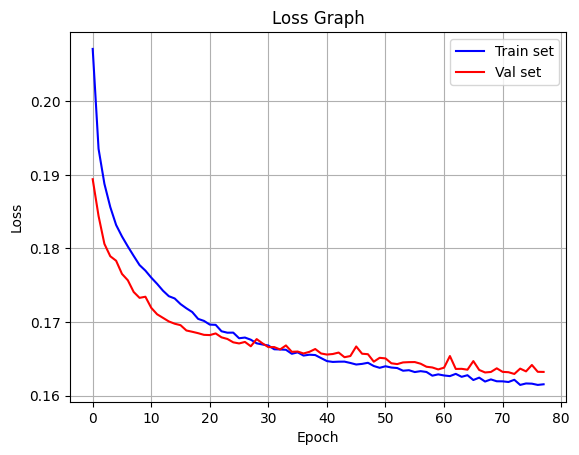

In [8]:
y_loss = history.history['loss']
y_vloss = history.history['val_loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_loss, c = 'blue', label="Train set")
plt.plot(x_len, y_vloss, c = 'red', label="Val set")

plt.legend(loc='upper right')
plt.grid()
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [9]:
# Test1 predict
pred_test_target1 = model_Parallel.predict([test_set1_ASOS, test_set1_AWS], batch_size = batch)
obsv_test_target1 = test_target1

# Test2 predict
pred_test_target2 = model_Parallel.predict([test_set2_ASOS, test_set2_AWS], batch_size = batch)
obsv_test_target2 = test_target2

# Test3 predict
pred_test_target3 = model_Parallel.predict([test_set3_ASOS, test_set3_AWS], batch_size = batch)
obsv_test_target3 = test_target3

137/137 [==============================] - 1s 4ms/step


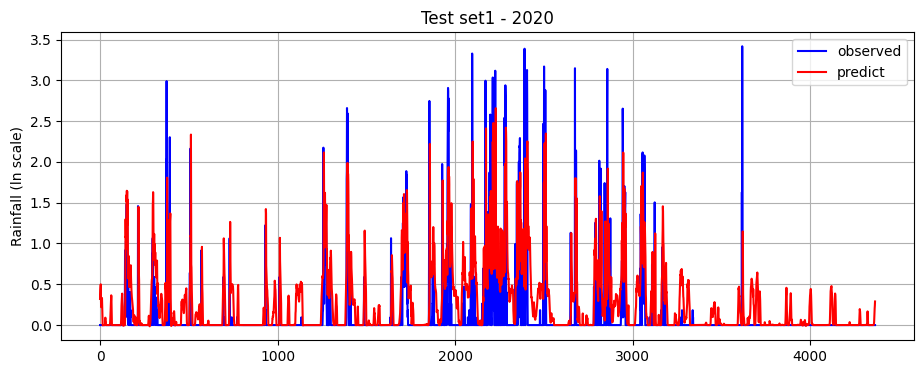

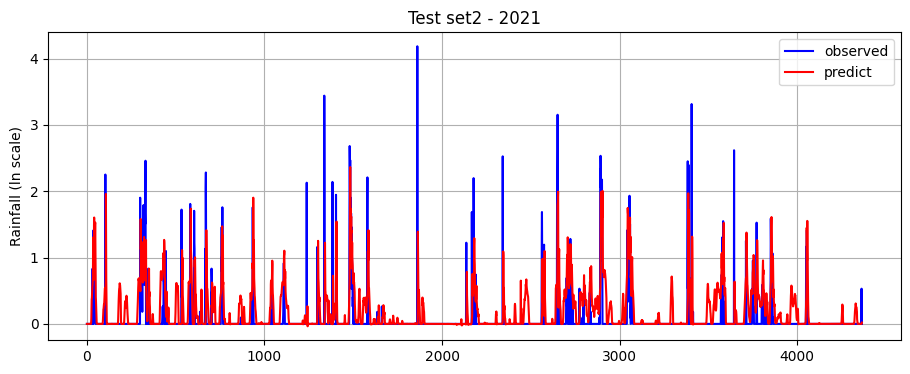

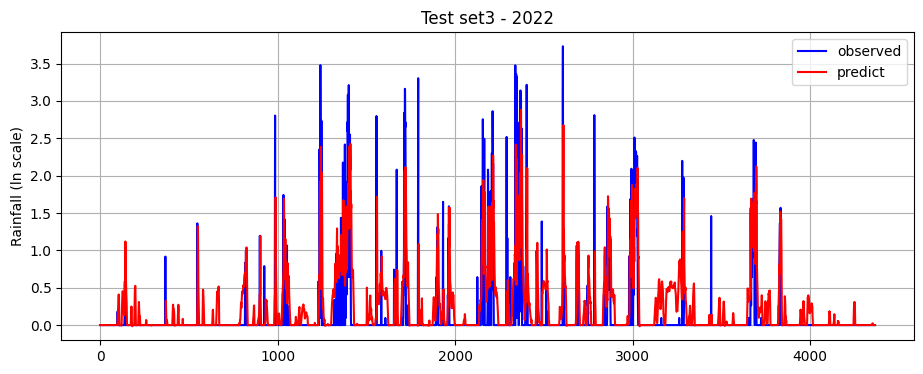

In [10]:
# graph of test1 (ln scale)

index_test = np.arange(4366)
b1 = range(0, 4366)
b2 = range(0, 4366)
b3 = range(0, 4366)

plt.figure(figsize = (11, 4))
plt.plot(index_test[b1], obsv_test_target1[b1], 'b', label = 'observed')
plt.plot(index_test[b1], pred_test_target1[b1], 'r', label = 'predict')

plt.legend(loc='upper right')
plt.grid()
plt.title('Test set1 - 2020')
plt.xlabel('\n')
plt.ylabel('Rainfall (ln scale)')
plt.show()

# graph of test2

plt.figure(figsize = (11, 4))
plt.plot(index_test[b2], obsv_test_target2[b2], 'b', label = 'observed')
plt.plot(index_test[b2], pred_test_target2[b2], 'r', label = 'predict')

plt.legend(loc='upper right')
plt.grid()
plt.title('Test set2 - 2021')
plt.xlabel('\n')
plt.ylabel('Rainfall (ln scale)')
plt.show()

# graph of test3

plt.figure(figsize = (11, 4))
plt.plot(index_test[b3], obsv_test_target3[b3], 'b', label = 'observed')
plt.plot(index_test[b3], pred_test_target3[b3], 'r', label = 'predict')

plt.legend(loc='upper right')
plt.grid()
plt.title('Test set3 - 2022')
plt.xlabel('\n')
plt.ylabel('Rainfall (ln scale)')
plt.show()

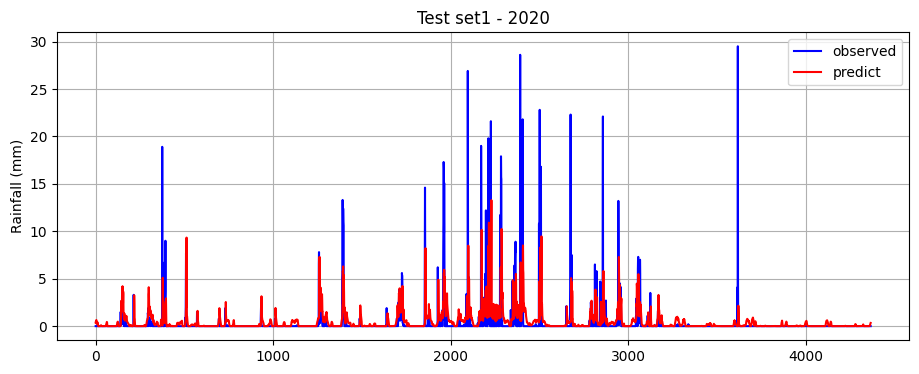

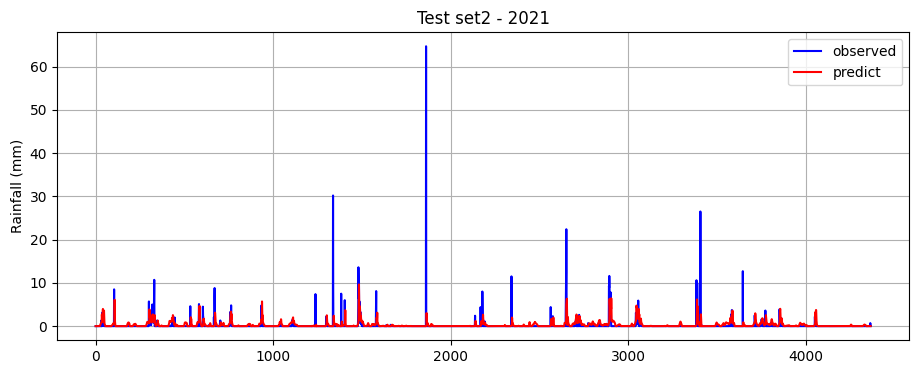

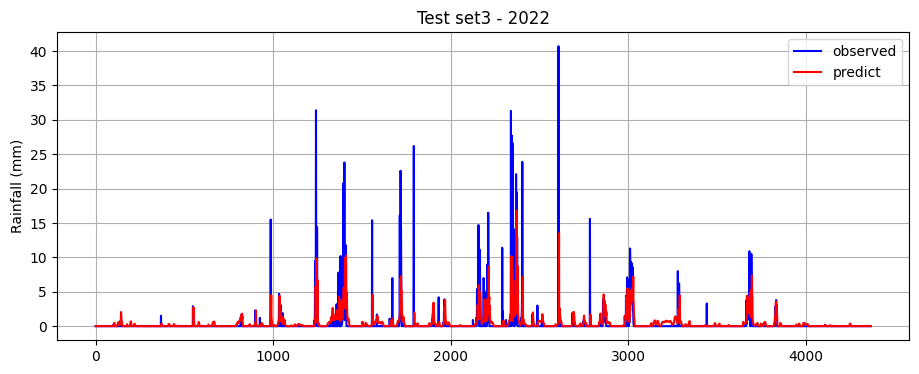

In [11]:
# graph of test1 (mm)

index_test = np.arange(4366)
b1 = range(0, 4366)
b2 = range(0, 4366)
b3 = range(0, 4366)

plt.figure(figsize = (11, 4))
plt.plot(index_test[b1], np.power(math.exp(1), obsv_test_target1[b1]) - 1, 'b', label = 'observed')
plt.plot(index_test[b1], np.power(math.exp(1), pred_test_target1[b1]) - 1, 'r', label = 'predict')

plt.legend(loc='upper right')
plt.grid()
plt.title('Test set1 - 2020')
plt.xlabel('\n')
plt.ylabel('Rainfall (mm)')
plt.show()

# graph of test2

plt.figure(figsize = (11, 4))
plt.plot(index_test[b2], np.power(math.exp(1), obsv_test_target2[b2]) - 1, 'b', label = 'observed')
plt.plot(index_test[b2], np.power(math.exp(1), pred_test_target2[b2]) - 1, 'r', label = 'predict')

plt.legend(loc='upper right')
plt.grid()
plt.title('Test set2 - 2021')
plt.xlabel('\n')
plt.ylabel('Rainfall (mm)')
plt.show()

# graph of test3

plt.figure(figsize = (11, 4))
plt.plot(index_test[b3], np.power(math.exp(1), obsv_test_target3[b3]) - 1, 'b', label = 'observed')
plt.plot(index_test[b3], np.power(math.exp(1), pred_test_target3[b3]) - 1, 'r', label = 'predict')

plt.legend(loc='upper right')
plt.grid()
plt.title('Test set3 - 2022')
plt.xlabel('\n')
plt.ylabel('Rainfall (mm)')
plt.show()

In [12]:
np.save('modeling_data/P_pred_test1', pred_test_target1)
np.save('modeling_data/P_pred_test2', pred_test_target2)
np.save('modeling_data/P_pred_test3', pred_test_target3)

np.save('modeling_data/obsv_test_target1_P', obsv_test_target1)
np.save('modeling_data/obsv_test_target2_P', obsv_test_target2)
np.save('modeling_data/obsv_test_target3_P', obsv_test_target3)